# 以下代码不涉及模型的保存//5

# 计时器

In [1]:
import time
import warnings
from contextlib import contextmanager

import torch


class TimeCounter:
    names = dict()

    # Avoid instantiating every time
    @classmethod
    def count_time(cls, log_interval=1, warmup_interval=1, with_sync=True):
        assert warmup_interval >= 1

        def _register(func):
            if func.__name__ in cls.names:
                raise RuntimeError(
                    'The registered function name cannot be repeated!')
            # When adding on multiple functions, we need to ensure that the
            # data does not interfere with each other
            cls.names[func.__name__] = dict(
                count=0,
                pure_inf_time=0,
                log_interval=log_interval,
                warmup_interval=warmup_interval,
                with_sync=with_sync)

            def fun(*args, **kwargs):
                count = cls.names[func.__name__]['count']
                pure_inf_time = cls.names[func.__name__]['pure_inf_time']
                log_interval = cls.names[func.__name__]['log_interval']
                warmup_interval = cls.names[func.__name__]['warmup_interval']
                with_sync = cls.names[func.__name__]['with_sync']

                count += 1
                cls.names[func.__name__]['count'] = count

                if with_sync and torch.cuda.is_available():
                    torch.cuda.synchronize()
                start_time = time.perf_counter()

                result = func(*args, **kwargs)

                if with_sync and torch.cuda.is_available():
                    torch.cuda.synchronize()

                elapsed = time.perf_counter() - start_time

                if count >= warmup_interval:
                    pure_inf_time += elapsed
                    cls.names[func.__name__]['pure_inf_time'] = pure_inf_time

                    if count % log_interval == 0:
                        times_per_count = 1000 * pure_inf_time / (
                            count - warmup_interval + 1)
                        print(
                            f'[{func.__name__}]-{count} times per count: '
                            f'{times_per_count:.1f} ms',
                            flush=True)

                return result

            return fun

        return _register

    @classmethod
    @contextmanager
    def profile_time(cls,
                     func_name,
                     log_interval=1,
                     warmup_interval=1,
                     with_sync=True):
        assert warmup_interval >= 1
        warnings.warn('func_name must be globally unique if you call '
                      'profile_time multiple times')

        if func_name in cls.names:
            count = cls.names[func_name]['count']
            pure_inf_time = cls.names[func_name]['pure_inf_time']
            log_interval = cls.names[func_name]['log_interval']
            warmup_interval = cls.names[func_name]['warmup_interval']
            with_sync = cls.names[func_name]['with_sync']
        else:
            count = 0
            pure_inf_time = 0
            cls.names[func_name] = dict(
                count=count,
                pure_inf_time=pure_inf_time,
                log_interval=log_interval,
                warmup_interval=warmup_interval,
                with_sync=with_sync)

        count += 1
        cls.names[func_name]['count'] = count

        if with_sync and torch.cuda.is_available():
            torch.cuda.synchronize()
        start_time = time.perf_counter()

        yield

        if with_sync and torch.cuda.is_available():
            torch.cuda.synchronize()
        elapsed = time.perf_counter() - start_time

        if count >= warmup_interval:
            pure_inf_time += elapsed
            cls.names[func_name]['pure_inf_time'] = pure_inf_time

            if count % log_interval == 0:
                times_per_count = 1000 * pure_inf_time / (
                    count - warmup_interval + 1)
                print(
                    f'[{func_name}]-{count} times per count: '
                    f'{times_per_count:.1f} ms',
                    flush=True)

C:\Users\82516\.conda\envs\tf1\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# top

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
# import tensorflow.compat.v1 as tf 
# tf.disable_v2_behavior()
# tf.compat.v1.disable_eager_execution()
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from numpy import shape
import matplotlib.ticker as ticker
%matplotlib inline

import math
import time
import torch

from torch.autograd import Variable


import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

C:\Users\82516\.conda\envs\tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\82516\.conda\envs\tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\82516\.conda\envs\tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\82516\.conda\envs\tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:5

In [3]:
# 查看位置
import os
print(os.path.abspath('.'))


D:\a_study\model\chuneng\WindChaser-master - 副本\data


In [4]:
print(tf.__version__)

1.14.0


In [5]:
# 第一行代码相当于 D6
# df = pd.read_csv('WindPower2012.csv', on_bad_lines='skip')
df = pd.read_csv('D5.csv', on_bad_lines='skip')

print("Length of original data : ", len(df))

# 计算每小时的平均值并另存为新数据帧
data2 =[]   
for i in range (len(df)//12):
    data2.append(df[i * 12:(i + 1) * 12].mean())
data2 = pd.DataFrame(data2)
print("Length of hourly averaged data : ", len(data2))

# 6-11列的数据
data= data2.iloc[:, 5:11].values # 对于数据集windpower2012使用这个
# data= data2.iloc[:, 0:7].values  # 对于数据集WTH使用这个



Length of original data :  87840
Length of hourly averaged data :  7320


In [6]:
rnn_unit = 10      #隐藏层单元
input_size = 5     # 表示输入层为5，数据为6-11列，实际使用7-11做输入预测6的结果，可以理解为输入层有5个节点
output_size=1      # 表示输出层的维度是1，实际输出第6列的结果
lr=0.0006         # 学习率

batch_size = 14   # 每个batch中样本的数量
time_step = 12  # 每个样本输入的时间步数

# 大概占0.68306，简单理解成训练集和测试集7：3
train_begin = 0
train_end = math.ceil(len(data2) * 0.7)
test_begin = math.ceil(len(data2) * 0.7)

test_len = 180   # 测试数据的长度
# iter_time = 100  # 迭代次数
iter_time = 100 # 迭代次数

# RNN 输出节点权重和偏差
# 决定rnn单元的输出和下一步的状态
weights = {
           'in':tf.Variable(tf.random.normal([input_size,rnn_unit])),
           'out':tf.Variable(tf.random.normal([rnn_unit,1]))
           }

biases = {
          'in':tf.Variable(tf.constant(0.1,shape=[rnn_unit,])),
          'out':tf.Variable(tf.constant(0.1,shape=[1,]))
          }


In [7]:
print(test_begin)

5124


In [8]:
# 获取训练数据功能：加载 LSTM 的训练数据
# 输入: batch_size, time_step, train_begin, train_end
# 输出: batch_index, train_x, train_y

def get_train_data(batch_size, time_step, train_begin, train_end):
    batch_index = []
    
    # 规范化数据
    scaler_for_x = MinMaxScaler(feature_range=(0, 1))
    scaled_x_data = scaler_for_x.fit_transform(data)
    
    scaler_for_y = MinMaxScaler(feature_range=(0, 1))
    scaled_y_data = scaler_for_y.fit_transform(data[:, 0].reshape(-1, 1))
    
    # 获得训练数据
    normalized_train_data = scaled_x_data[train_begin:train_end]
    train_x, train_y = [], []
    for i in range(len(normalized_train_data) - time_step):
        if i % batch_size == 0:
            batch_index.append(i)
        x = normalized_train_data[i:i + time_step, 1:6]
        y = normalized_train_data[i+1:i + time_step+1, 0, np.newaxis]
        train_x.append(x.tolist())
        train_y.append(y.tolist())
    batch_index.append((len(normalized_train_data) - time_step))
    return batch_index, train_x, train_y 

In [9]:
# 获取测试数据功能：LSTM 的负载测试数据
# 输入: time_step, test_begin, test_len
# 输出: test_x, test_y, scaler_for_x, scaler_for_y

def get_test_data(time_step, test_begin, test_len):
    
    # 规范化数据
    scaler_for_x = MinMaxScaler(feature_range=(0, 1))   # 归一化处理 minmaxscaler
    scaler_for_y = MinMaxScaler(feature_range=(0, 1))
    scaled_x_data = scaler_for_x.fit_transform(data)
    scaled_y_data = scaler_for_y.fit_transform(data[:, 0].reshape(-1, 1))
    
    # 获得测试数据
    size = test_len// time_step    # 用于计算测试集数据的数量
    normalized_test_data = scaled_x_data[test_begin: (test_begin+test_len)]
    normalized_test_lable = scaled_x_data[test_begin+1: (test_begin+test_len+1)]
    test_y = normalized_test_lable[:,0]
    test_x = []
    for i in range(size):
        x = normalized_test_data[i * time_step:(i + 1) * time_step, 1:6]
        test_x.append(x.tolist())
    return test_x, test_y, scaler_for_x, scaler_for_y

In [10]:
# LSTM 函数：循环神经网络的定义
# 输入: X
# 输出: pred, final_states

def lstm(X):
    batch_size = tf.shape(X)[0]
    time_step = tf.shape(X)[1]
    w_in = weights['in']
    b_in = biases['in']
    
    # reshape to (batch_size * time_step, input_size)
    input = tf.reshape(X, [-1, input_size])  #将张量转换为 3D 数组作为隐藏层的输入
    input_rnn = tf.matmul(input, w_in) + b_in
    input_rnn = tf.reshape(input_rnn, [-1, time_step, rnn_unit])
    
    # 创建要展开的 LSTM 单元
    cell = tf.contrib.rnn.BasicLSTMCell(rnn_unit)
    # cell=tf.contrib.rnn.core_rnn_cell.BasicLSTMCell(rnn_unit)
    # cell=tf.nn.rnn_cell.BasicLSTMCell(rnn_unit)
    
    # 在每个时间步，重新初始化隐藏状态
    init_state = cell.zero_state(batch_size, dtype=tf.float32)
    
    # 生成预测
    # 在 TensorFlow 中创建一个动态 RNN 对象。
    # 此对象将在每个时间步长动态执行 LSTM 单元的展开
    output_rnn, final_states = tf.nn.dynamic_rnn(cell, input_rnn, initial_state=init_state,
                                                 dtype=tf.float32)
    
    output = tf.reshape(output_rnn, [-1, rnn_unit])
    w_out = weights['out']
    b_out = biases['out']
    ## 获取最后输出
    pred = tf.matmul(output, w_out) + b_out
    return pred, final_states

In [11]:
# train_lstm function: 训练 LSTM 模型、进行预测、计算预测误差
# 输入: batch_size, time_step, train_begin, train_end, test_begin, iter_time, test_len
# 输出: test_y, test_predict, loss_list, rmse, mae
# test_y：测试集，test_predict：预测值
# @TimeCounter.count_time()
def train_lstm(batch_size, time_step, train_begin, train_end, test_begin, iter_time, test_len):
    # 设置状态存储/提取
    X = tf.placeholder(tf.float32, shape=[None, time_step, input_size])
    Y = tf.placeholder(tf.float32, shape=[None, time_step, output_size])    
    batch_index, train_x, train_y = get_train_data(batch_size, time_step, train_begin, train_end)
    
    print("Training parameters:***************************************************")
    print("batch size: ", batch_size)
    print("Number of batches: ", len(batch_index))
    print("Shape of training samples:", shape(train_x))
    print("Shape of training labels:", shape(train_y))

    pred, _ = lstm(X)
    
    ## Loss and optimizer 损失和优化器
    loss = tf.reduce_mean(tf.square(tf.reshape(pred, [-1]) - tf.reshape(Y, [-1])))
    train_op = tf.train.AdamOptimizer(lr).minimize(loss)
    loss_list = []
    print("Training begins: *****************************************************")
    
    
    ## 训练步骤优化
    """
    累积损失以监控培训进度。
    20 次迭代通常足以达到可接受的精度。    
    """
    
    with tf.Session() as sess:
        # 初始化变量
        sess.run(tf.global_variables_initializer())
        # 重复训练 100 次
        for epoch in range(iter_time):
            for step in range(len(batch_index) - 2):
                ## 计算批量损失 loss
                _, loss_ = sess.run([train_op, loss], feed_dict={X: train_x[batch_index[step]:batch_index[step + 1]],
                                                                 Y: np.array(train_y[batch_index[step]:batch_index[step + 1]], dtype=float).reshape(batch_size,time_step,1)})
                loss_list.append(loss_)
            
            # Show loss every 5 iterations   
            if epoch % 5 == 0:
                print("Epoch:", epoch, " loss:",loss_)
            
                #if step%100==0:
                    #print('Epoch:', epoch, 'steps: ', step,  'loss:', loss_)            
        print("Training Optimization Finished! ***************************************")
          
        """Testing the model"""
        print("Prediction Begins: ****************************************************")
        
        
        df = pd.read_csv('data6.csv', on_bad_lines='skip')
        # 计算每小时的平均值并另存为新数据帧
        data2 =[]   
        for i in range (len(df)//12):
            data2.append(df[i * 12:(i + 1) * 12].mean())
        data2 = pd.DataFrame(data2)
        # 6-11列的数据
        data= data2.iloc[:, 5:11].values # 对于数据集windpower2012使用这个
        test_begin = math.ceil(len(data2) * 0.7)

        
        
        test_x, test_y, scaler_for_x, scaler_for_y = get_test_data(time_step, test_begin, test_len)
        print("Shape of testing samples:", shape(test_x))

                      
        test_predict = []
        for step in range(len(test_x)):
            prob = sess.run(pred, feed_dict={X: [test_x[step]]})
            predict = prob.reshape((-1))
            test_predict.extend(predict)
        #test_predict = scaler_for_y.inverse_transform(np.array(test_predict).reshape(-1,1))
        #test_y = scaler_for_y.inverse_transform(np.array(test_y).reshape(-1,1))
        
        test_y = np.array(test_y).reshape(-1,1)
        test_predict = np.array(test_predict).reshape(-1,1) 
        print("Shape of testing lables:", shape(test_predict))
        test_predict = scaler_for_y.inverse_transform(test_predict).reshape(-1,1)
        test_y= scaler_for_y.inverse_transform(test_y).reshape(-1,1)
       
        
        #calculate the error of predication 
        rmse = np.sqrt(mean_squared_error(test_predict, test_y))
        mae = mean_absolute_error(y_pred=test_predict, y_true=test_y)
        print ("Mean absolute error:", "{:.3f}".format(mae), 
               "Root mean squared error:", "{:.3f}".format(rmse))
        
#         # 加俩新的标准
#         # MAPE
#         # 计算每个数据点的百分比误差
#         test_predict_mape = test_predict
#         # 避免零除错误，将零值替换为一个小值（例如1e-6），这个方法不是很好，会导致最后计算的值偏大
#         # 后面再调
#         test_y_mape = np.where(test_y == 0, 1e-6, test_y)
#         percentage_errors = np.abs((test_y_mape - test_predict_mape) / test_y_mape) * 100
#         # 计算平均绝对百分比误差
#         mape = np.mean(percentage_errors)
#         print("MAPE:", "{:.3f}%".format(mape))
        
#         # 计算相关系数 (Pearson相关系数)
        
#         test_predict_cc = np.where(test_predict == 0, 1e-16, test_predict)
#         test_y_cc = np.where(test_y == 0, 1e-6, test_y)
#         cc = np.corrcoef(test_predict_cc, test_y_cc)[0, 1]
#         print("Correlation Coefficient (CC):", "{:.3f}".format(cc))
        
#         print("-----------------")
#         print("test_predict_cc",shape(test_predict_cc))
#         print("test_y_cc",shape(test_y_cc))
        


        
        
        
        
        
        
        
        
        
        

        # visualization
        figure = plt.figure(figsize=(8,5))
        # axes = figure.add_subplot(1, 1, 1, facecolor='ghostwhite')
        
        axes = figure.add_subplot(1, 1, 1)
        
        # 中文图
        # axes.plot(test_y, lw='2', c = 'red', label='真实值')     
        # axes.plot(test_predict, lw='2', c = 'darkblue', label='LSTM 预测值')
        # axes.set_title('真实值 vs. 预测值 ', fontsize = 12)
        # axes.set_xlabel('时间序列', fontsize = 12)
        # axes.set_ylabel('风', fontsize = 12)
        
        # axes.grid(ls = '--' , c = 'darkgrey', alpha=0.5)
        
        # 英文图
        axes.plot(test_y, lw='2', c = 'red', label='Real Testing Data')     
        axes.plot(test_predict, lw='2', c = 'darkblue', label='LSTM Forecasted Data')
        axes.set_title('Real Testing vs. Forecasted Wind Power', fontsize = 12)
        axes.set_xlabel('Time Series', fontsize = 12)
        axes.set_ylabel('Wind Power(MWh)', fontsize = 12)
        
        axes.grid(ls = '--' , c = 'darkgrey', alpha=0.5)
        axes.legend(fontsize=12)
        
       
        
        
        


        
        
    # return test_y, test_predict, loss_list, rmse, mae, mape
    return test_y, test_predict, loss_list, rmse, mae


Training parameters:***************************************************
batch size:  14
Number of batches:  367
Shape of training samples: (5112, 12, 5)
Shape of training labels: (5112, 12, 1)
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it 

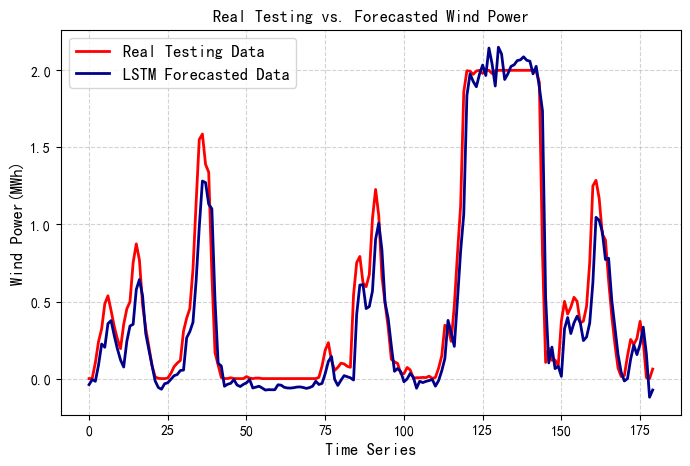

In [12]:
# %%time
# test_y, test_predict, loss_list, rmse, mae, mape = train_lstm(batch_size, time_step, train_begin, train_end, test_begin, iter_time, test_len)
test_y, test_predict, loss_list, rmse, mae = train_lstm(batch_size, time_step, train_begin, train_end, test_begin, iter_time, test_len)

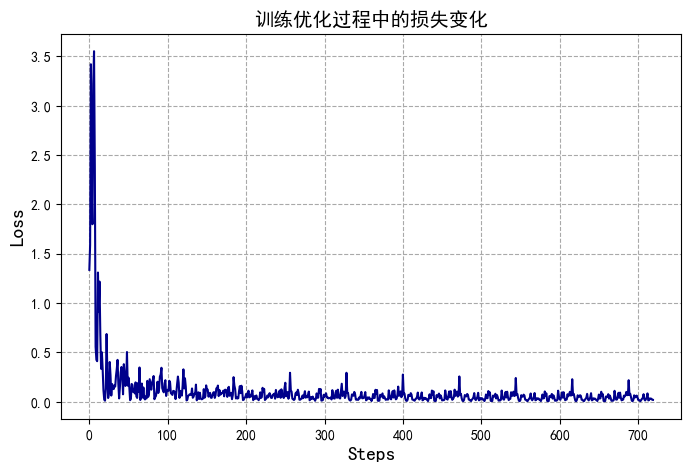

In [11]:
figure = plt.figure(figsize=(8,5))
# axes = figure.add_subplot(1, 1, 1, facecolor='ghostwhite')

axes = figure.add_subplot(1, 1, 1)
axes.plot(loss_list, c = 'darkblue')    
axes.set_title('训练优化过程中的损失变化', fontsize = 14)
axes.set_xlabel('Steps', fontsize = 14)
axes.set_ylabel('Loss', fontsize = 14)
axes.grid(ls = '--' , c = 'darkgrey')

# 下面生成整体图的需要修改成自适应的范围代码（还没改）

C:\Users\82516\.conda\envs\tf1\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


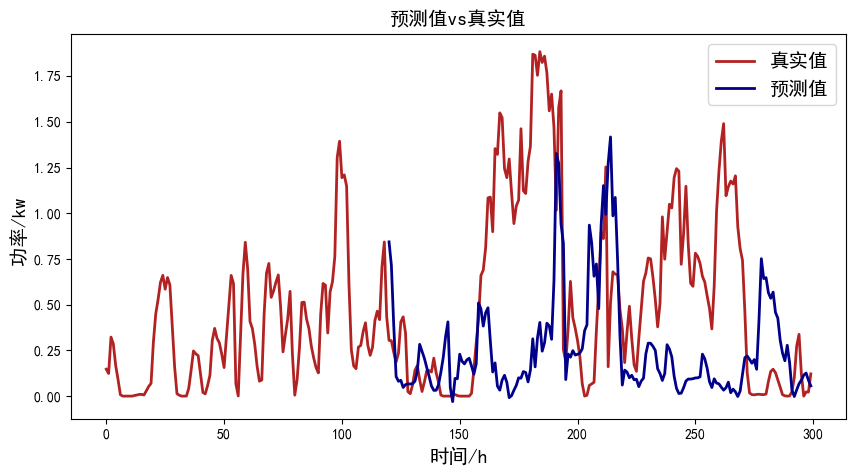

In [12]:
figure = plt.figure( figsize=(10,5))
# axes = figure.add_subplot(1, 1, 1, facecolor='ghostwhite')

axes = figure.add_subplot(1, 1, 1)
plot_data = data[:, 0]
axes.plot( plot_data[5880:6180], lw='2', c = 'firebrick', label='真实值')  
axes.plot([None for _ in range(120)] + [x for x in test_predict], lw='2', c = 'darkblue', label= '预测值') 
axes.set_title('预测值vs真实值', fontsize = 14)
axes.set_xlabel('时间/h', fontsize = 14)
axes.set_ylabel('功率/kw ', fontsize = 14)
# axes.grid(ls = '--' , c = 'darkgrey')
axes.legend(fontsize=14)
figure.savefig('预测 .png') 

## 对上面的模型进行预测精度评价

LSTM模型的预测精度可以用多种指标来衡量，以下是一些常用的指标：

<font color = blue>均方误差（Mean Squared Error，MSE）：衡量预测值与真实值之间的平均误差的平方
越小越好

1. 均方根误差（Root Mean Square Error，RMSE）：RMSE是预测值和实际值之间的差异的标准差，它度量了模型预测的偏差大小。RMSE越小，表示模型的预测越准确。
越小越好

2. 平均绝对误差（Mean Absolute Error，MAE）：MAE是预测值和实际值之间的差异的平均值，它度量了模型的平均预测偏差。MAE越小，表示模型的预测越准确。
越小越好

3. 系统预测误差（Mean Absolute Percentage Error，MAPE）：MAPE是预测值和实际值之间的百分比差异的平均值，它度量了模型的平均预测偏差。MAPE越小，表示模型的预测越准确。
越小越好

4. 对称平均绝对百分比误差（Symmetric Mean Absolute Percentage Error，SMAPE）：SMAPE是预测值和实际值之间的百分比差异的对称平均值，它度量了模型的平均预测偏差。SMAPE越小，表示模型的预测越准确。
越小越好

5. 相关系数（Correlation Coefficient）：相关系数度量了预测值和实际值之间的线性关系强度，取值范围为-1到1。相关系数越接近1或-1，表示模型的预测越准确。
越接近1/-1越好

决定系数（Coefficient of Determination, R²）：度量预测值与真实值之间的相关性，值越接近1表示预测模型的拟合效果越好。
越接近1越好

不同的评估指标可以适用于不同的场景和需求，需要根据具体情况选择合适的指标来评估模型的预测精度。

In [15]:
# test_y：测试集，test_predict：预测值
# 评估预测精度
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(test_y, test_predict)
rmse = np.sqrt(mse)
r2 = r2_score(test_y, test_predict)

print('MSE:', mse)
print('RMSE:', rmse)
print('R^2:', r2)

MSE: 0.047171723038586244
RMSE: 0.2171905224419018
R^2: 0.8361890883484019


In [16]:
# test_y：测试集，test_predict：预测值
# 计算 MAE mape smape
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test_y, test_predict)
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(test_y, test_predict) # 有问题

# smape


print('MAE:', mae)
print('mape:', mape)


MAE: 0.1377240358557966
mape: 2632847015576.8433


In [22]:
# python计算rmse
# rmse计算了平均误差的平方根，因此与实际值之间的误差越小，RMSE的值也越小。
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error

mse = np.sum((test_y - test_predict) ** 2) / len(test_y)
rmse = sqrt(mse)
mae = np.sum(np.absolute(test_y - test_predict)) / len(test_y)
r2 = 1-mse/ np.var(test_y)#均方误差/方差
print(" mae:",mae,"mse:",mse," rmse:",rmse," r2:",r2)

#ai

rmse = np.sqrt(mean_squared_error(test_y, test_predict))

print("RMSE:",rmse)


 mae: 0.1377240358557966 mse: 0.047171723038586244  rmse: 0.2171905224419018  r2: 0.8361890883484019
RMSE: 0.2171905224419018


# 试试

In [1]:
import tensorflow as tf
import numpy as np

# 创建一个新的LSTM模型
def create_lstm_model():
    # 在这里定义你的LSTM模型架构
    # 例如：
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(units=64, return_sequences=True),
        tf.keras.layers.Dense(units=1)
    ])
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# 加载已有模型的权重和参数
def load_pretrained_model(model, model_path):
    model.load_weights(model_path)

# 迁移已有模型的权重和参数
new_lstm_model = create_lstm_model()
load_pretrained_model(new_lstm_model, './saved_model55/model55')

# 准备新数据
# 加载新的数据，进行预处理，得到new_data

# 训练新模型
new_lstm_model.fit(new_data, epochs=10)  # 根据数据集的大小和性质选择合适的迭代次数

# 保存更新后的模型
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.save(sess, 'updated_lstm_model/model.ckpt')


C:\Users\82516\.conda\envs\tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\82516\.conda\envs\tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\82516\.conda\envs\tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\82516\.conda\envs\tf1\lib\site-packages\tensorflow\python\framework\dtypes.py:5

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


C:\Users\82516\.conda\envs\tf1\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\82516\.conda\envs\tf1\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\82516\.conda\envs\tf1\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\82516\.conda\envs\tf1\lib\site-packages\tensorboard\compat

NotImplementedError: Streaming restore not supported from name-based checkpoints when graph building. File a feature request if this limitation bothers you. As a workaround, consider either using tf.train.Checkpoint to load name-based checkpoints or enabling eager execution.

In [3]:
import tensorflow as tf

# 创建一个新的LSTM模型
def create_lstm_model():
    # 在这里定义你的LSTM模型架构
    # 例如：
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(units=64, return_sequences=True),
        tf.keras.layers.Dense(units=1)
    ])
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# 加载已有模型的权重和参数
def load_pretrained_model(model, model_path):
    # saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver.restore(sess, model_path)

# 迁移已有模型的权重和参数
new_lstm_model = create_lstm_model()
load_pretrained_model(new_lstm_model, './saved_model55/model55')

# 准备新数据
# 加载新的数据，进行预处理，得到new_data

# 训练新模型
new_lstm_model.fit(new_data, epochs=10)  # 根据数据集的大小和性质选择合适的迭代次数

# 保存更新后的模型
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.save(sess, 'updated_lstm_model/model.ckpt')


ValueError: No variables to save

In [6]:
import tensorflow as tf
import numpy as np

# 创建一个新的LSTM模型
def create_lstm_model():
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(units=64, return_sequences=True),
        tf.keras.layers.Dense(units=1)
    ])
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# 加载已有模型的权重和参数
def load_pretrained_model(sess, model_path):
    saver = tf.train.Saver()
    saver.restore(sess=sess, save_path =  model_path)

# 准备新数据
# 加载新的数据，进行预处理，得到new_data
# 请确保 new_data 包含与原模型的输入格式兼容的数据

# 创建 TensorFlow 1.x 会话
with tf.Session() as sess:
    new_lstm_model = create_lstm_model()

    # 初始化变量
    # sess.run(tf.global_variables_initializer())
    # 读取上次的模型的参数
    saver = tf.compat.v1.train.import_meta_graph('./saved_model55/model55.meta')
    save_path = './saved_model55/model55'
    # 恢复原始模型的权重
    saver.restore(sess=sess, save_path=save_path)

    
    

    print('----------')
    # 训练新模型
    sess.run(tf.global_variables_initializer())
    # 使用 feed_dict 喂入新数据
    for _ in range(10):  # 根据数据集的大小和性质选择合适的迭代次数
        sess.run(train_op, feed_dict={input_placeholder: new_data, target_placeholder: target_data})
    
    # 保存更新后的模型
    saver = tf.train.Saver()
    saver.save(sess, 'updated_lstm_model/model.ckpt')


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Restoring parameters from ./saved_model55/model55
----------


NameError: name 'train_op' is not defined

# bottom